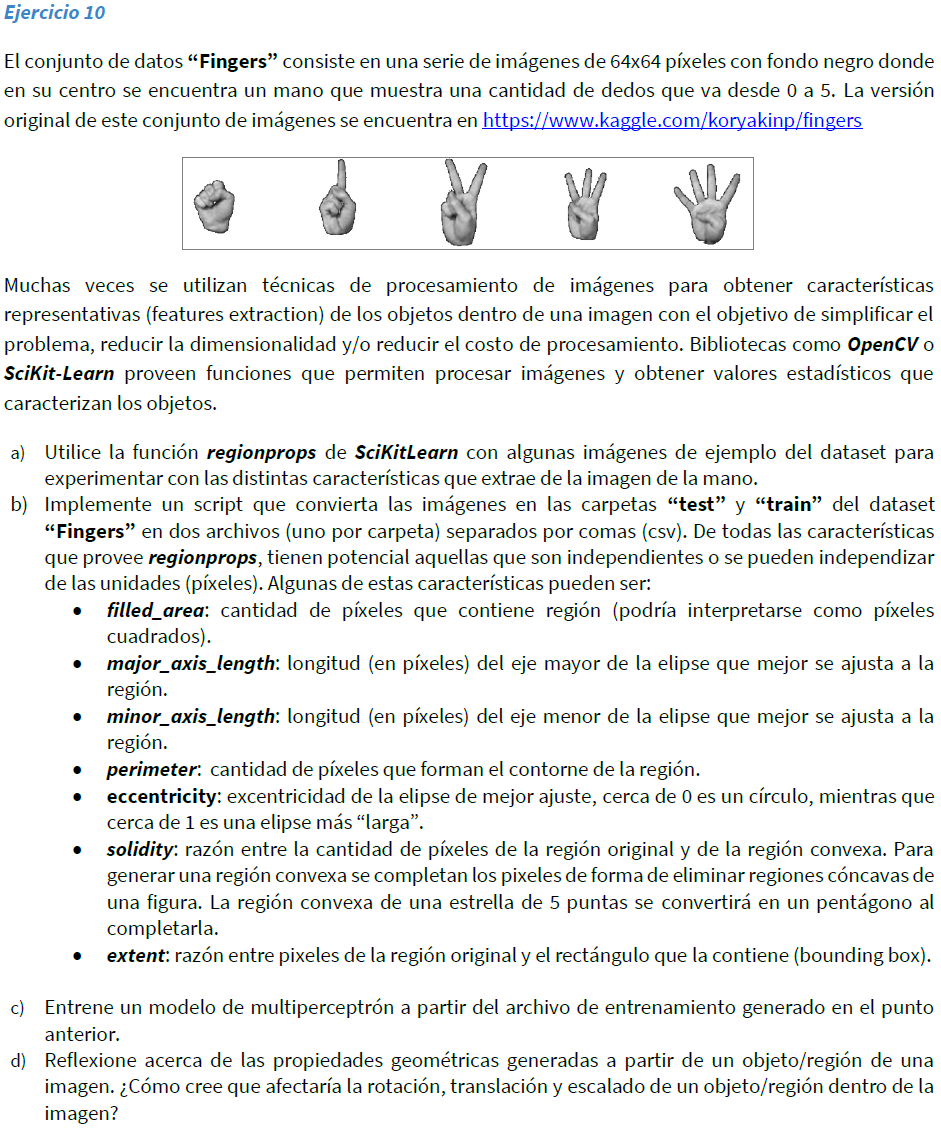

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Funciones auxiliares para convertir imagenes en carpetas a caracteristicas geométricas en un archivo separado por comas (csv) 


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.measure import find_contours, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage import io
import pandas as pd
import numpy as np
import glob
import math

# funcion para extraer características geométricas de un objeto dentro de una imagen
def extraer_caracteristicas(imagen):
    # busca umbral global con método estadístico de Otsu
    umbral = threshold_otsu(imagen)

    # binariza la imagen
    imagen_bn = (imagen > umbral)*1

    # cierra pequeños huecos/cortes que pudiera tener la imagen de la mano
    imagen_bn = closing(imagen_bn, square(3))

    # remueve artefactos que pudiera tener la imagen en los bordes
    imagen_lista = clear_border(imagen_bn)

    # extrae regiones de pixeles conectados, para los ejemplos debería haber
    # solo una única region. Para cada region obtiene distintas propiedades
    # que caracterizan a dicha region, ej: area, perimetro, centro, eje mayor y
    # menor, orientacion, coordenadas y área del recuadro que la contiene
    regiones = regionprops(imagen_lista)

    return (regiones[0], imagen_lista)


def mostrar_imagen(axs, imagen, cmap='gray'):
    # remueve ejes de los graficos
    axs.get_xaxis().set_ticks([])
    axs.get_yaxis().set_ticks([])

    axs.imshow(imagen, cmap=cmap)


# funcion para procesar todas las imagenes de manos mostrando dedos de una carpeta
# y generar un archivo csv con las características geometricas de lad mismas
def convertir_dataset(dir_orig, dir_arch_dest):

    # definición de columnas a guardar en el archivo csv
    columnas=['AreaNorm', 'PerimNorm', 'RazonEjes', 'Excentricidad', 'Solidez',
                               'Extension', 'CantDedos']

    # recupera nombrs de archivos
    print(dir_orig)
    archivos = glob.glob(dir_orig+'*.png')

    data = np.empty((0, len(columnas)))

    # recorre la lista de archivos para procesar cada imagen. Guarda las características
    # en un arreglo temporal
    for nro, archivo in enumerate(archivos):

        print('\rTransformando %d imágenes: %6.2f%%' % (len(archivos), 100*(nro+1)/len(archivos)), end='')
        imagen = io.imread(archivo)

        # el nombre de archivo tiene la cantidad de dedos que se estan mostrando
        cant_dedos = int(archivo[-6])

        # extrae caracteristicas
        props, imagen_bn = extraer_caracteristicas(imagen)

        area = props.filled_area                # area en pixeles (incluyendo huecos)
        ej_mayor = props.major_axis_length      # largo en pixeles del eje mayor en elipse de m. a.
        ej_menor = props.minor_axis_length      # largo en pixeles del eje menor en elipse de m. a.
        perim = props.perimeter                 # perimetro en pixeles
        # EXCENTRICIDAD: relacion con elipse que contiene la region.
        # cercano a 0 es un circulo, cercano a 1 es mas estirada la elipse
        excentr = props.eccentricity
        # SOLIDEZ: razon entre la cantidad de pixeles de la region original y de la
        # region convexa. Para generar una region convexa se completan los pixeles
        # de forma de eliminar regiones convexas de una figura. La región convexa
        # de una estrella de 5 puntas se convertira en un pentágono al completarla
        solidez = props.solidity
        # EXTENSION: razon entre pixeles de la region original y el rectangulo que
        # la contiene (bounding box)
        extension = props.extent

        # normaliza algunos valores para para que las unidades sean independientes de los pixeles
        area = area /  ((ej_mayor*ej_menor))
        perim = perim / ((ej_mayor+ej_menor)/2)
        #perim = perim / math.sqrt(ej_mayor*ej_menor)
        razon_ej = ej_menor/ej_mayor
        data = np.append(data, np.array([[area, perim, razon_ej, excentr,
                                          solidez, extension, cant_dedos]]), axis=0)

    df = pd.DataFrame(columns=columnas, data = data)
    df.to_csv(dir_arch_dest)

In [13]:
DEDOS_DIR = DATOS_DIR + 'Fingers/fingers/'
convertir_dataset(DEDOS_DIR+'train/', DEDOS_DIR+'fingers_train.csv')
convertir_dataset(DEDOS_DIR+'test/' , DEDOS_DIR+'fingers_test.csv')

../../Datos-Fuentes/Datos/Fingers/fingers/train/
Transformando 18000 imágenes: 100.00%../../Datos-Fuentes/Datos/Fingers/fingers/test/
Transformando 3600 imágenes: 100.00%

: 